In [1]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns

In [2]:
import anndata

rna = anndata.read_h5ad("/lmh_data/data/sclab/Human_M1_10x/scRNA.h5ad")
rna.obs.cell_type = rna.obs.cell_type.cat.rename_categories({'Oligo': 'ODC'})
rna = rna[rna.obs['cell_type'].isin(['Astro', 'OPC', 'ODC']),:]
rna

View of AnnData object with n_obs × n_vars = 3793 × 50281
    obs: 'cell_type', 'domain'

In [3]:
nCountsPerGene = np.sum(rna.X, axis=0)
nCellsPerGene = np.sum(rna.X>0, axis=0)

# Show info
print("Number of counts (in the dataset units) per gene:", nCountsPerGene.min(), " - " ,nCountsPerGene.max())
print("Number of cells in which each gene is detected:", nCellsPerGene.min(), " - " ,nCellsPerGene.max())

Number of counts (in the dataset units) per gene: 0.0  -  506440.0
Number of cells in which each gene is detected: 0  -  3793


In [4]:
nCells = rna.X.shape[0]

# pySCENIC thresholds
minCountsPerGene=3*.01*nCells # 3 counts in 1% of cells
print("minCountsPerGene: ", minCountsPerGene)

minSamples=.01*nCells # 1% of cells
print("minSamples: ", minSamples)

minCountsPerGene:  113.78999999999999
minSamples:  37.93


In [5]:
import scanpy as sc
# simply compute the number of genes per cell (computers 'n_genes' column)
sc.pp.filter_cells(rna, min_genes=0)
sc.pp.filter_genes(rna, min_cells=10)
rna

/root/miniconda3/envs/scenic/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


AnnData object with n_obs × n_vars = 3793 × 19439
    obs: 'cell_type', 'domain', 'n_genes'
    var: 'n_cells'

/tmp/ipykernel_86528/76684241.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
/tmp/ipykernel_86528/76684241.py:11: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
/tmp/ipykernel_86528/76684241.py:12: UserWarning: 



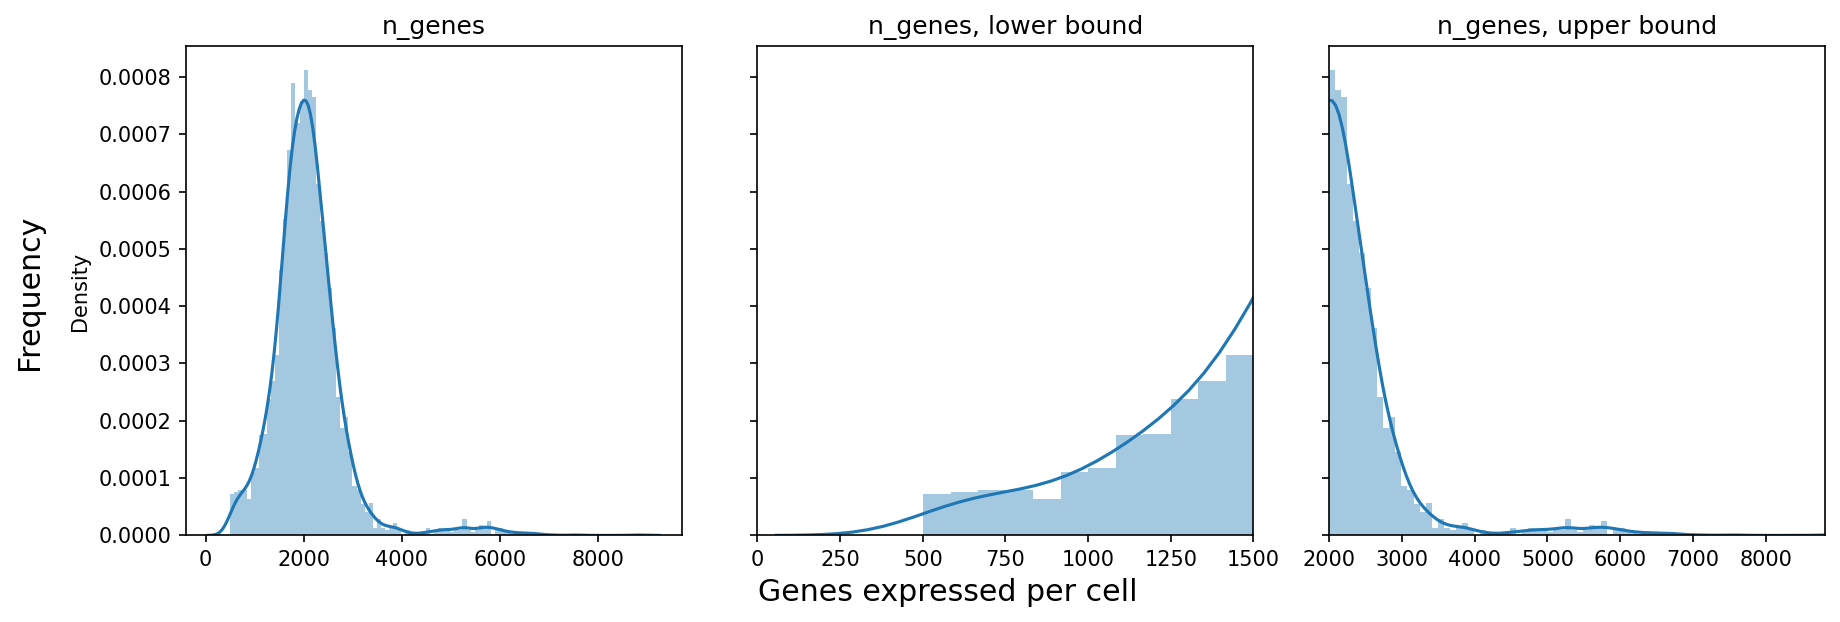

In [6]:
import matplotlib.pyplot as plt

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=True)

x = rna.obs['n_genes']
x_lowerbound = 1500
x_upperbound = 2000
nbins=100

sns.distplot(x, ax=ax1, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax2, norm_hist=True, bins=nbins)
sns.distplot(x, ax=ax3, norm_hist=True, bins=nbins)

ax2.set_xlim(0,x_lowerbound)
ax3.set_xlim(x_upperbound, rna.obs['n_genes'].max() )

for ax in (ax1,ax2,ax3): 
  ax.set_xlabel('')

ax1.title.set_text('n_genes')
ax2.title.set_text('n_genes, lower bound')
ax3.title.set_text('n_genes, upper bound')

fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='x-large')
fig.text(0.5, 0.0, 'Genes expressed per cell', ha='center', va='center', size='x-large')

fig.tight_layout()

In [7]:
# tf_names = load_tf_names('/lmh_data/data/sclab/SCENIC/allTFs_hg38.txt')

TF = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_TF', sep='\t', index_col=0)
TF_cofactors = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_TF_cofactors', sep='\t', index_col=0)
RBP = pd.read_csv('/lmh_data/data/sclab/source/Homo_sapiens_RBP', sep='\t', index_col=0, header=None)
TF, TF_cofactors, RBP = TF['Symbol'].unique(), TF_cofactors['Symbol'].unique(), RBP[1].unique()
tf_names = set(TF) | set(TF_cofactors) | set(RBP)

In [8]:
def cal_adjacencies(cell_type):
    _rna = rna[rna.obs['cell_type']==cell_type,:]
    _rna = pd.DataFrame(_rna.X, index=_rna.obs_names, columns=_rna.var_names)
    adjacencies = grnboost2(_rna, tf_names=tf_names, verbose=True, seed=123)
    adjacencies.to_csv('/lmh_data/data/sclab/SCENIC/scenic_adjacencies_{}.csv'.format(cell_type))

In [9]:
cal_adjacencies('Astro')
cal_adjacencies('OPC')
cal_adjacencies('ODC')

preparing dask client
parsing input
creating dask graph
12 partitions
computing dask graph
shutting down client and local cluster
finished
preparing dask client
parsing input
creating dask graph
12 partitions
computing dask graph
shutting down client and local cluster
finished
preparing dask client
parsing input
creating dask graph
12 partitions
computing dask graph
shutting down client and local cluster
finished
